In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime  
from nltk.tokenize import word_tokenize  
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
import numpy as np
import re


import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer

# function to make n-grams
from nltk.util import ngrams 
from nltk import everygrams

from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(vocabulary = myvocabulary, stop_words = 'english')
# tfs = tfidf.fit_transform(corpus.values())

from gensim.corpora import Dictionary
import itertools
from collections import defaultdict
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

In [2]:
df = pd.read_csv('../data/processed/cleaned_data_2.csv')
# increasing max length for all columns and rows
pd.set_option('display.max_colwidth', -1)

pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
# functions for tokenizing, word count and wordcloud
tknz = TweetTokenizer()



def tokenize_tweet(s):
    """
    Tokenize each text into a list of words removing the ashtags
    """
    tokens = tknz.tokenize(s)
    return [w for w in tokens]

def tokenize_ngrams(s, ngram):
    """
    Tokenize each text into a list of words removing the ashtags in n-grams
    """
    tokens =  ngrams(s, ngram)
    return [w for w in tokens]
    


def get_tokens_frequency_df(series):
    """
    Count each time the same word appeared in the series
    :return: dataFrame
    """
    corpus_lists = [doc for doc in series.dropna() if doc]
    dictionary = Dictionary(corpus_lists)
    corpus_bow = [dictionary.doc2bow(doc) for doc in corpus_lists]
    token_freq_bow = defaultdict(int)
    for token_id, token_sum in itertools.chain.from_iterable(corpus_bow):
        token_freq_bow[token_id] += token_sum

    return pd.DataFrame(list(token_freq_bow.items()), columns=['token_id', 'token_count']).assign(
        token=lambda df1: df1.apply(lambda df2: dictionary.get(df2.token_id), axis=1),
        doc_appeared=lambda df1: df1.apply(lambda df2: dictionary.dfs[df2.token_id], axis=1)).reindex(
        labels=['token_id', 'token', 'token_count', 'doc_appeared'], axis=1).set_index('token_id')


def plot_word_cloud(df, top_n):
    word_cloud = WordCloud(background_color='white', colormap='magma', contour_width=1,
                           contour_color='orange', relative_scaling=0.5)

    sorted_freq_dict = dict(df[['token', 'token_count']].nlargest(top_n, columns='token_count').values)
    wc = word_cloud.generate_from_frequencies(frequencies=sorted_freq_dict, max_font_size=40)

    _, ax = plt.subplots(figsize=(15, 8))
    ax.set_title('Term Frequency', fontsize=16)

    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')

    

In [4]:
# for some reason we keep having missing values....
df.isna().sum()

tweet_low                          0 
handle_count                       0 
no_handle_no_special_no_sin_ash    0 
tweet_length                       0 
character_count                    0 
lemmatized                         3 
lemmatized_1                       3 
lemmatized_final                   3 
tweet_without_stopwords            26
tweet_without_stopwords_and_2      39
neg_label                          0 
dtype: int64

In [5]:
len(df)

42031

In [6]:
# not very useful as most of these were filled with either handles or only emoticons
nan_values = df.loc[df['tweet_without_stopwords_and_2'].isna()]
nan_values.head(5)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,neg_label
385,what i doð,0,what i do,14,7,what i do,what i do,what i do,NaN,NaN,0
566,@user it's at $7.25,1,it's at,16,6,it 's at,it 's at,it's at,'s,NaN,0
1549,@user @user @user @user @user @user @user @user @user @user,10,,10,0,NaN,NaN,NaN,NaN,NaN,0
2878,it was in 2008,0,it was in,15,7,it be in,it be in,it be in,NaN,NaN,0
2984,@user then why are you,1,then why are you,19,13,then why be you,then why be you,then why be you,NaN,NaN,0


In [7]:
# filtering to have non-missing values
df = df.loc[df['tweet_without_stopwords_and_2'].notnull()]

In [8]:
df.isna().sum()

tweet_low                          0
handle_count                       0
no_handle_no_special_no_sin_ash    0
tweet_length                       0
character_count                    0
lemmatized                         0
lemmatized_1                       0
lemmatized_final                   0
tweet_without_stopwords            0
tweet_without_stopwords_and_2      0
neg_label                          0
dtype: int64

In [9]:
df.head(5)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,neg_label
0,13 days to go #gettingthere,0,days to go #gettingthere,30,21,day to go # gettingthere,day to go #gettingthere,day to go # gettingthere,day go # gettingthere,day gettingthere,0
1,@anggxo get off my twitter fag,1,get off my twitter fag,23,18,get off my twitter fag,get off my twitter fag,get off my twitter fag,get twitter fag,get twitter fag,1
2,these hoes got more bodies than a cemetery&#128056;&#9749;&#65039;.,0,these hoes got more bodies than a cemetery,58,35,these hoe get more body than a cemetery,these hoe get more body than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,hoe get body cemetery,1
3,a friend just told me she's afraid to go to dc rally &amp; be attacked by #berniebros or the @user racists cuz she's not white.,1,a friend just told me she's afraid to go to dc rally amp be attacked by #berniebros or the racists cuz she's not white,124,95,a friend just tell me she 's afraid to go to dc rally amp be attack by # berniebros or the racist cuz she 's not white,a friend just tell me she 's afraid to go to dc rally amp be attack by #berniebros or the racist cuz she 's not white,a friend just tell me she's afraid to go to dc rally amp be attack by # berniebros or the racist cuz she's not white,friend tell 's afraid go dc rally amp attack # berniebros racist cuz 's white,friend tell afraid rally amp attack berniebros racist cuz white,0
4,i've noticed a lot of #icontf16 presentations mention happiness. wonder if profession has above average happiness? @user,1,i've noticed a lot of #icontf presentations mention happiness wonder if profession has above average happiness,117,95,i 've notice a lot of # icontf presentation mention happiness wonder if profession have above average happiness,i 've notice a lot of #icontf presentation mention happiness wonder if profession have above average happiness,i've notice a lot of # icontf presentation mention happiness wonder if profession have above average happiness,'ve notice lot # icontf presentation mention happiness wonder profession average happiness,'ve notice lot icontf presentation mention happiness wonder profession average happiness,0


# Dividing into positive and negative dfs

In [10]:
# dividing into positive and negative dfs
df_pos = df.loc[df['neg_label'] == 0]

In [11]:
len(df_pos)

21383

In [12]:
df_neg = df.loc[df['neg_label'] == 1]

In [13]:
len(df_neg)

20609

# Tokenization

### Positive DF

Making a few final changes to the very final column which is tweet without stopwords and with words at least 3 character long.
Ashtags are mixed with the words. We'll perform a separate analysis to look at only ashtags. In this instance we want to transform negation partcicles n't into 'not' and get rid of single apotrophes that were left there by lemmatization.

In [14]:
# replacing n't with not
df_pos['tweet_without_stopwords_and_2'] = df_pos['tweet_without_stopwords_and_2'].str.replace("n't", "not")
df_pos['tweet_without_stopwords_and_2'] = df_pos['tweet_without_stopwords_and_2'].str.replace("'ve", "")
df_pos['tweet_without_stopwords_and_2'] = df_pos['tweet_without_stopwords_and_2'].str.replace("'re", "")
df_pos['tweet_without_stopwords_and_2'] = df_pos['tweet_without_stopwords_and_2'].str.replace("wan na", "wanna")
df_pos['tweet_without_stopwords_and_2'] = df_pos['tweet_without_stopwords_and_2'].str.replace("gon na", "gonna")




In [15]:
# getting rid of single apostrophes
df_pos['tweet_without_stopwords_and_2'] = df_pos['tweet_without_stopwords_and_2'].str.replace(" '", "")
df_pos['tweet_without_stopwords_and_2'] = df_pos['tweet_without_stopwords_and_2'].str.replace("' ", "")
 
df_pos.head(5)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,neg_label
0,13 days to go #gettingthere,0,days to go #gettingthere,30,21,day to go # gettingthere,day to go #gettingthere,day to go # gettingthere,day go # gettingthere,day gettingthere,0
3,a friend just told me she's afraid to go to dc rally &amp; be attacked by #berniebros or the @user racists cuz she's not white.,1,a friend just told me she's afraid to go to dc rally amp be attacked by #berniebros or the racists cuz she's not white,124,95,a friend just tell me she 's afraid to go to dc rally amp be attack by # berniebros or the racist cuz she 's not white,a friend just tell me she 's afraid to go to dc rally amp be attack by #berniebros or the racist cuz she 's not white,a friend just tell me she's afraid to go to dc rally amp be attack by # berniebros or the racist cuz she's not white,friend tell 's afraid go dc rally amp attack # berniebros racist cuz 's white,friend tell afraid rally amp attack berniebros racist cuz white,0
4,i've noticed a lot of #icontf16 presentations mention happiness. wonder if profession has above average happiness? @user,1,i've noticed a lot of #icontf presentations mention happiness wonder if profession has above average happiness,117,95,i 've notice a lot of # icontf presentation mention happiness wonder if profession have above average happiness,i 've notice a lot of #icontf presentation mention happiness wonder if profession have above average happiness,i've notice a lot of # icontf presentation mention happiness wonder if profession have above average happiness,'ve notice lot # icontf presentation mention happiness wonder profession average happiness,notice lot icontf presentation mention happiness wonder profession average happiness,0
5,getting for this weekends shows! #country #music #lylepierce,0,getting for this weekends shows #country #music #lylepierce,62,52,get for this weekend show # country # music # lylepierce,get for this weekend show #country #music #lylepierce,get for this weekend show # country # music # lylepierce,get weekend show # country # music # lylepierce,get weekend show country music lylepierce,0
6,@user my final legislative session day has officially begun! @user @user #albany,3,my final legislative session day has officially begun #albany,69,53,my final legislative session day have officially begin # albany,my final legislative session day have officially begin #albany,my final legislative session day have officially begin # albany,final legislative session day officially begin # albany,final legislative session day officially begin albany,0


In [16]:
# make new columns for positives with a list of words 
df_pos['tweet_low_tok'] = df_pos[df_pos ['tweet_low'].notna()]['tweet_low'].apply(tokenize_tweet)
df_pos['lemmatized_1_tok'] = df_pos[df_pos ['lemmatized_1'].notna()]['lemmatized_1'].apply(tokenize_tweet)
df_pos['lemmatized_final_tok'] = df_pos[df_pos ['lemmatized_final'].notna()]['lemmatized_final'].apply(tokenize_tweet)
df_pos['tweet_without_stopwords_and_2_tok'] = df_pos[df_pos ['tweet_without_stopwords_and_2'].notna()]['tweet_without_stopwords_and_2'].apply(tokenize_tweet)


In [17]:
df_pos.head(10)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,neg_label,tweet_low_tok,lemmatized_1_tok,lemmatized_final_tok,tweet_without_stopwords_and_2_tok
0,13 days to go #gettingthere,0,days to go #gettingthere,30,21,day to go # gettingthere,day to go #gettingthere,day to go # gettingthere,day go # gettingthere,day gettingthere,0,"[13, days, to, go, #gettingthere]","[day, to, go, #gettingthere]","[day, to, go, #, gettingthere]","[day, gettingthere]"
3,a friend just told me she's afraid to go to dc rally &amp; be attacked by #berniebros or the @user racists cuz she's not white.,1,a friend just told me she's afraid to go to dc rally amp be attacked by #berniebros or the racists cuz she's not white,124,95,a friend just tell me she 's afraid to go to dc rally amp be attack by # berniebros or the racist cuz she 's not white,a friend just tell me she 's afraid to go to dc rally amp be attack by #berniebros or the racist cuz she 's not white,a friend just tell me she's afraid to go to dc rally amp be attack by # berniebros or the racist cuz she's not white,friend tell 's afraid go dc rally amp attack # berniebros racist cuz 's white,friend tell afraid rally amp attack berniebros racist cuz white,0,"[a, friend, just, told, me, she's, afraid, to, go, to, dc, rally, &, be, attacked, by, #berniebros, or, the, @user, racists, cuz, she's, not, white, .]","[a, friend, just, tell, me, she, ', s, afraid, to, go, to, dc, rally, amp, be, attack, by, #berniebros, or, the, racist, cuz, she, ', s, not, white]","[a, friend, just, tell, me, she's, afraid, to, go, to, dc, rally, amp, be, attack, by, #, berniebros, or, the, racist, cuz, she's, not, white]","[friend, tell, afraid, rally, amp, attack, berniebros, racist, cuz, white]"
4,i've noticed a lot of #icontf16 presentations mention happiness. wonder if profession has above average happiness? @user,1,i've noticed a lot of #icontf presentations mention happiness wonder if profession has above average happiness,117,95,i 've notice a lot of # icontf presentation mention happiness wonder if profession have above average happiness,i 've notice a lot of #icontf presentation mention happiness wonder if profession have above average happiness,i've notice a lot of # icontf presentation mention happiness wonder if profession have above average happiness,'ve notice lot # icontf presentation mention happiness wonder profession average happiness,notice lot icontf presentation mention happiness wonder profession average happiness,0,"[i've, noticed, a, lot, of, #icontf16, presentations, mention, happiness, ., wonder, if, profession, has, above, average, happiness, ?, @user]","[i, ', ve, notice, a, lot, of, #icontf, presentation, mention, happiness, wonder, if, profession, have, above, average, happiness]","[i've, notice, a, lot, of, #, icontf, presentation, mention, happiness, wonder, if, profession, have, above, average, happiness]","[notice, lot, icontf, presentation, mention, happiness, wonder, profession, average, happiness]"
5,getting for this weekends shows! #country #music #lylepierce,0,getting for this weekends shows #country #music #lylepierce,62,52,get for this weekend show # country # music # lylepierce,get for this weekend show #country #music #lylepierce,get for this weekend show # country # music # lylepierce,get weekend show # country # music # lylepierce,get weekend show country music lylepierce,0,"[getting, for, this, weekends, shows, !, #country, #music, #lylepierce]","[get, for, this, weekend, show, #country, #music, #lylepierce]","[get, for, this, weekend, show, #, country, #, music, #, lylepierce]","[get, weekend, show, country, music, lylepierce]"
6,@user my final legislative session day has officially begun! @user @user #albany,3,my final legislative session day has officially begun #albany,69,53,my final legislative session day have officially begin # albany,my final l

Inserting into a dataframe overall count of words for positive

In [18]:
tokens_pos = get_tokens_frequency_df(df_pos['tweet_without_stopwords_and_2_tok'])

In [19]:
tokens_pos = tokens_pos.sort_values(by='token_count', ascending = False)
tokens_pos.head(10)


,token,token_count,doc_appeared
token_id,,,
0,day,2118,1948
123,love,1965,1820
119,not,1608,1502
22,get,1327,1273
226,happy,1253,1186
3,amp,1104,987
38,life,924,852
265,make,842,804
136,today,831,823


### Negative DF

Removing apostrophes and n't as we did for postive words first

In [20]:
df_neg

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,neg_label
1,@anggxo get off my twitter fag,1,get off my twitter fag,23,18,get off my twitter fag,get off my twitter fag,get off my twitter fag,get twitter fag,get twitter fag,1
2,these hoes got more bodies than a cemetery&#128056;&#9749;&#65039;.,0,these hoes got more bodies than a cemetery,58,35,these hoe get more body than a cemetery,these hoe get more body than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,hoe get body cemetery,1
7,@lucas_wright955 @michaelgt03 faggots,2,faggots,9,7,faggot,faggot,faggot,faggot,faggot,1
10,"@hoponthebeast i found her right here, good job unfollowing me btw faggot http://t.co/kd3iseiold",1,i found her right here good job unfollowing me btw faggot,60,47,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,find right good job unfollowing btw faggot,find right good job unfollowing btw faggot,1
14,"technology ain't doin nothing, but making these hoes look better",0,technology ain't doin nothing but making these hoes look better,64,54,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing make hoe look good,technology n't doin nothing make hoe look good,1
...,...,...,...,...,...,...,...,...,...,...,...
42024,"rt @makeup_sex: trash talked by many . hated by some . & guess how many fucks i give , its less than one .",1,rt trash talked by many hated by some guess how many fucks i give its less than one,95,66,rt trash talk by many hat by some guess how many fuck i give its less than one,rt trash talk by many hat by some guess how many fuck i give its less than one,rt trash talk by many hat by some guess how many fuck i give its less than one,rt trash talk many hat guess many fuck give less one,trash talk many hat guess many fuck give less one,1
42026,@_elenaraquel_ its swag bitch aha,1,its swag bitch aha,19,15,its swag bitch aha,its swag bitch aha,its swag bitch aha,swag bitch aha,swag bitch aha,1
42028,rt @_groovymovie: &#8220;@shane_a1: hmu talmbout match but when i pull up its 30 other niccas wit ya &#128530;&#8221; smfh shit like that kill me,2,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,114,73,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match pull niccas wit ya smfh shit like kill,hmu talmbout match pull niccas wit smfh shit like kill,1
42029,rt @obey_jrock__: this is a true ride or die bitch &#128175; http://t.co/y1t8ctqn4u,1,rt this is a true ride or die bitch,45,27,rt this be a true ride or die bitch,rt this be a true ride or die bitch,rt this be a true ride or die bitch,rt true ride die bitch,true ride die bitch,1


In [21]:
# replacing n't with not
df_neg['tweet_without_stopwords_and_2'] = df_neg['tweet_without_stopwords_and_2'].str.replace("n't", "not")
df_neg.head(5)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,neg_label
1,@anggxo get off my twitter fag,1,get off my twitter fag,23,18,get off my twitter fag,get off my twitter fag,get off my twitter fag,get twitter fag,get twitter fag,1
2,these hoes got more bodies than a cemetery&#128056;&#9749;&#65039;.,0,these hoes got more bodies than a cemetery,58,35,these hoe get more body than a cemetery,these hoe get more body than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,hoe get body cemetery,1
7,@lucas_wright955 @michaelgt03 faggots,2,faggots,9,7,faggot,faggot,faggot,faggot,faggot,1
10,"@hoponthebeast i found her right here, good job unfollowing me btw faggot http://t.co/kd3iseiold",1,i found her right here good job unfollowing me btw faggot,60,47,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,find right good job unfollowing btw faggot,find right good job unfollowing btw faggot,1
14,"technology ain't doin nothing, but making these hoes look better",0,technology ain't doin nothing but making these hoes look better,64,54,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing make hoe look good,technology not doin nothing make hoe look good,1


In [22]:
# replacing 'n t' with not
df_neg['tweet_without_stopwords_and_2'] = df_neg['tweet_without_stopwords_and_2'].str.replace("n t", "not")
df_neg.head(5)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,neg_label
1,@anggxo get off my twitter fag,1,get off my twitter fag,23,18,get off my twitter fag,get off my twitter fag,get off my twitter fag,get twitter fag,get twitter fag,1
2,these hoes got more bodies than a cemetery&#128056;&#9749;&#65039;.,0,these hoes got more bodies than a cemetery,58,35,these hoe get more body than a cemetery,these hoe get more body than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,hoe get body cemetery,1
7,@lucas_wright955 @michaelgt03 faggots,2,faggots,9,7,faggot,faggot,faggot,faggot,faggot,1
10,"@hoponthebeast i found her right here, good job unfollowing me btw faggot http://t.co/kd3iseiold",1,i found her right here good job unfollowing me btw faggot,60,47,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,find right good job unfollowing btw faggot,find right good job unfollowing btw faggot,1
14,"technology ain't doin nothing, but making these hoes look better",0,technology ain't doin nothing but making these hoes look better,64,54,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing make hoe look good,technology not doin nothing make hoe look good,1


In [23]:
# getting rid of single apostrophes
df_neg['tweet_without_stopwords_and_2'] = df_neg['tweet_without_stopwords_and_2'].str.replace(" '", "")
df_neg['tweet_without_stopwords_and_2'] = df_neg['tweet_without_stopwords_and_2'].str.replace("' ", "")

In [24]:
# make new columns for negatives with a list of words 
df_neg['tweet_low_tok'] = df_neg[df_neg ['tweet_low'].notna()]['tweet_low'].apply(tokenize_tweet)
df_neg['lemmatized_1_tok'] = df_neg[df_neg ['lemmatized_1'].notna()]['lemmatized_1'].apply(tokenize_tweet)
df_neg['lemmatized_final_tok'] = df_neg[df_neg ['lemmatized_final'].notna()]['lemmatized_final'].apply(tokenize_tweet)
df_neg['tweet_without_stopwords_and_2_tok'] = df_neg[df_neg['tweet_without_stopwords_and_2'].notna()]['tweet_without_stopwords_and_2'].apply(tokenize_tweet)

In [25]:
df_neg.head(10)

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,neg_label,tweet_low_tok,lemmatized_1_tok,lemmatized_final_tok,tweet_without_stopwords_and_2_tok
1,@anggxo get off my twitter fag,1,get off my twitter fag,23,18,get off my twitter fag,get off my twitter fag,get off my twitter fag,get twitter fag,get twitter fag,1,"[@anggxo, get, off, my, twitter, fag]","[get, off, my, twitter, fag]","[get, off, my, twitter, fag]","[get, twitter, fag]"
2,these hoes got more bodies than a cemetery&#128056;&#9749;&#65039;.,0,these hoes got more bodies than a cemetery,58,35,these hoe get more body than a cemetery,these hoe get more body than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,hoe get body cemetery,1,"[these, hoes, got, more, bodies, than, a, cemetery, 🐸, ☕, ️, .]","[these, hoe, get, more, body, than, a, cemetery]","[these, hoe, get, more, body, than, a, cemetery]","[hoe, get, body, cemetery]"
7,@lucas_wright955 @michaelgt03 faggots,2,faggots,9,7,faggot,faggot,faggot,faggot,faggot,1,"[@lucas_wright955, @michaelgt03, faggots]",[faggot],[faggot],[faggot]
10,"@hoponthebeast i found her right here, good job unfollowing me btw faggot http://t.co/kd3iseiold",1,i found her right here good job unfollowing me btw faggot,60,47,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,find right good job unfollowing btw faggot,find right good job unfollowing btw faggot,1,"[@hoponthebeast, i, found, her, right, here, ,, good, job, unfollowing, me, btw, faggot, http://t.co/kd3iseiold]","[i, find, her, right, here, good, job, unfollowing, me, btw, faggot]","[i, find, her, right, here, good, job, unfollowing, me, btw, faggot]","[find, right, good, job, unfollowing, btw, faggot]"
14,"technology ain't doin nothing, but making these hoes look better",0,technology ain't doin nothing but making these hoes look better,64,54,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing make hoe look good,technology not doin nothing make hoe look good,1,"[technology, ain't, doin, nothing, ,, but, making, these, hoes, look, better]","[technology, ai, n't, doin, nothing, but, make, these, hoe, look, good]","[technology, ai, n't, doin, nothing, but, make, these, hoe, look, good]","[technology, not, doin, nothing, make, hoe, look, good]"
15,&#8220;@ciddyp_60: i wouldn't trust a male cheerleader @ all cuz .&#8221; cimarron got one &#128514; &amp; he got allll the bitches,2,i wouldn't trust a male cheerleader all cuz cimarron got one amp he got allll the bitches,111,73,i would n't trust a male cheerleader all cuz cimarron get one amp he get allll the bitch,i would n't trust a male cheerleader all cuz cimarron get one amp he get allll the bitch,i would n't trust a male cheerleader all cuz cimarron get one amp he get allll the bitch,would n't trust male cheerleader cuz cimarron get one amp get allll bitch,would not trust male cheerleader cuz cimarron get one amp get allll bitch,1,"[“, @ciddyp_60, :, i, wouldn't, trust, a, male, cheerleader, @, all, cuz, ., ”, cimarron, got, one, 😂, &, he, got, allll, the, bitches]","[i, would, n't, trust, a, male, cheerleader, all, cuz, cimarron, get, one, amp, he, get, allll, the, bitch]","[i, would, n't, trust, a, male, cheerleader, all, cuz, cimarron, get, one, amp, he, get, allll, the, bitch]","[would, not, trust, male, cheerleader, cuz, cimarron, get, one, amp, get, allll, bitch]"
17,@liveitupjersey @d_cassandra_d @bad_boy_six lol! that was a cyber bitch slap for sure!,3,lol that was a cyber bitch slap for sure,45,32,lol that be a cyber bitch slap for sure,lol that be a cyber bitch slap for sure,lol that be a cyber bitch

In [26]:
tokens_neg = get_tokens_frequency_df(df_neg['tweet_without_stopwords_and_2_tok'])

In [27]:
tokens_neg = tokens_neg.sort_values(by = 'token_count', ascending = False)
tokens_neg.head(10)

,token,token_count,doc_appeared
token_id,,,
21,bitch,11373,10642
5,hoe,4267,3957
16,not,3334,3017
1,get,3020,2764
121,like,2525,2304
36,pussy,2244,2144
42,fuck,2038,1880
35,nigga,1720,1549
153,ass,1589,1476


# Graphs most Recurring negative and positive words both ashtags and normal lexicon {1-gram}

## Plot top 10 positive words 1-gram (both ashtags and standard lexicon)

Text(0.5, 1.0, 'Most common positive words')

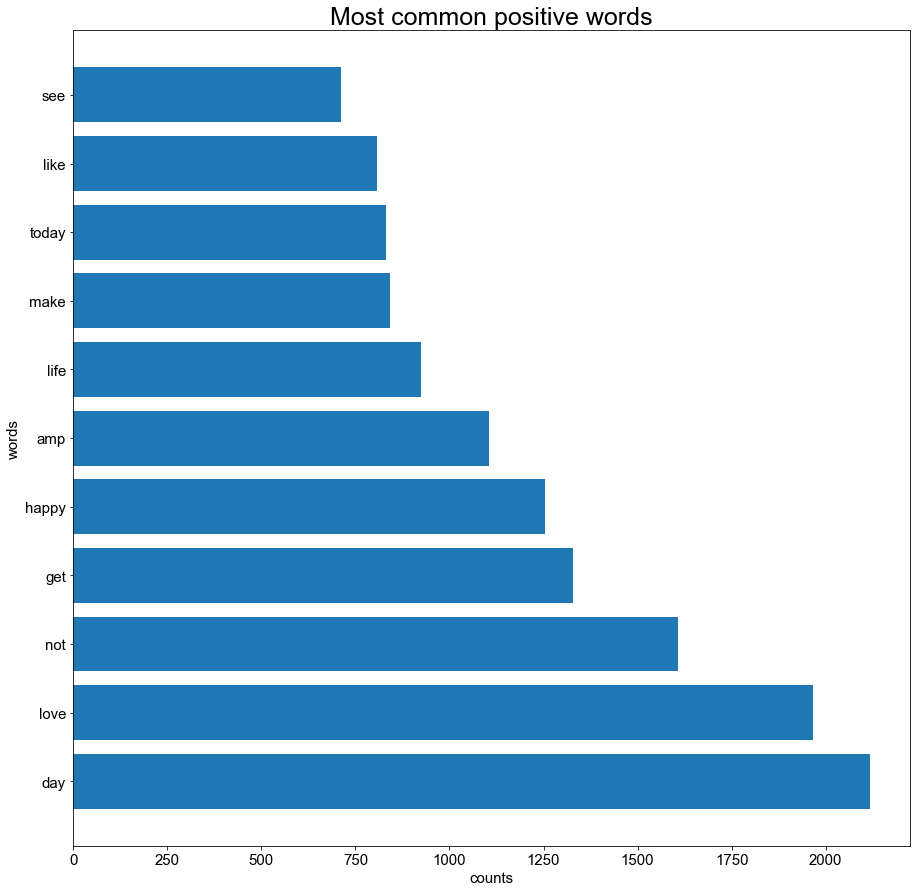

In [28]:
top_10_pos = tokens_pos[:11]

fig, ax = plt.subplots(figsize = (15,15))

plt.style.use('seaborn')
ax.barh(top_10_pos['token'], top_10_pos['token_count'])
plt.xlabel('counts', fontsize=15)
plt.ylabel('words',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Most common positive words', fontsize=25)

# fig.savefig('yourfilename.png')

## WordCloud Positive words 1-gram (both ashtags and standard lexicon)

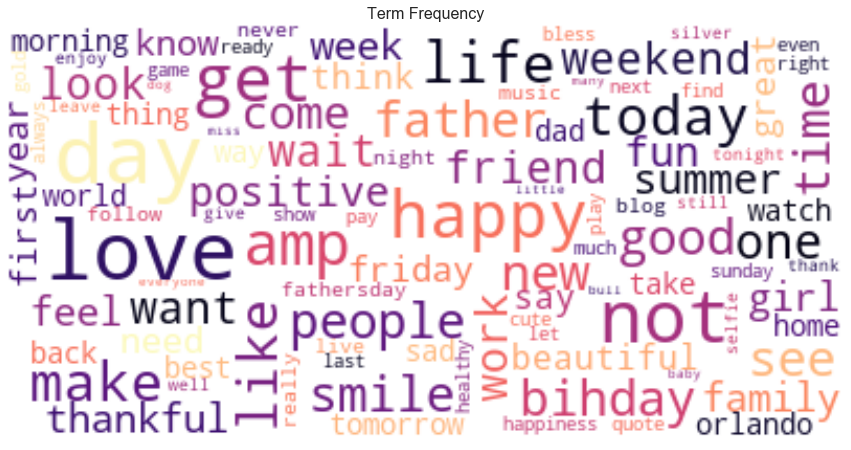

In [29]:
plot_word_cloud(tokens_pos,100)

## Plot top 10 negative words 1-gram (both ashtags and standard lexicon)

Text(0.5, 1.0, 'Most common negative words')

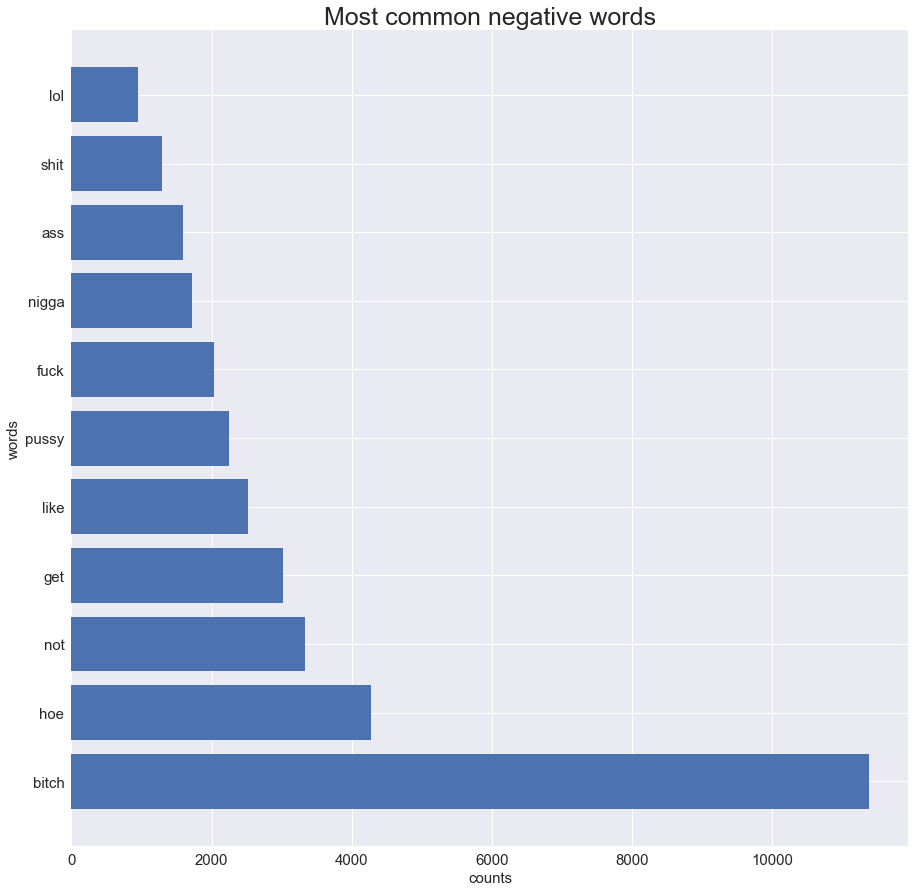

In [30]:
top_10_neg = tokens_neg[:11]

fig, ax = plt.subplots(figsize = (15,15))

plt.style.use('seaborn')
ax.barh(top_10_neg['token'], top_10_neg['token_count'])
plt.xlabel('counts', fontsize=15)
plt.ylabel('words',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Most common negative words', fontsize=25)

#fig.savefig('yourfilename.png')

## WordCloud Negative words 1-gram (both ashtags and standard lexicon)

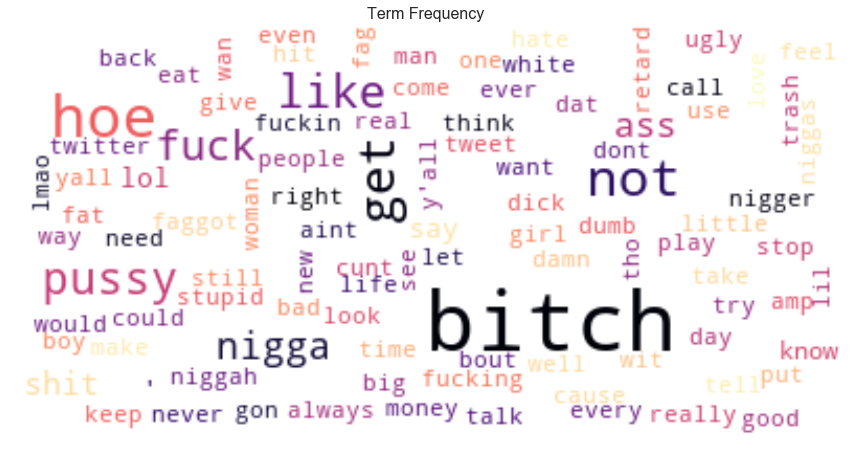

In [31]:
plot_word_cloud(tokens_neg,100)

# Graphs most Recurring negative and positive words both ashtags and normal lexicon {2-gram}

## Building 2-grams for positive



For this type of tokenization we'll first retrieve and use one of the lemmatized version of text with all stopwords and ashtags and words shorter than two charcaters.

In [32]:
df_pos_for_2_grams = df_pos[['no_handle_no_special_no_sin_ash', 'lemmatized_1', 'tweet_without_stopwords']]
df_pos_for_2_grams

,no_handle_no_special_no_sin_ash,lemmatized_1,tweet_without_stopwords
0,days to go #gettingthere,day to go #gettingthere,day go # gettingthere
3,a friend just told me she's afraid to go to dc rally amp be attacked by #berniebros or the racists cuz she's not white,a friend just tell me she 's afraid to go to dc rally amp be attack by #berniebros or the racist cuz she 's not white,friend tell 's afraid go dc rally amp attack # berniebros racist cuz 's white
4,i've noticed a lot of #icontf presentations mention happiness wonder if profession has above average happiness,i 've notice a lot of #icontf presentation mention happiness wonder if profession have above average happiness,'ve notice lot # icontf presentation mention happiness wonder profession average happiness
5,getting for this weekends shows #country #music #lylepierce,get for this weekend show #country #music #lylepierce,get weekend show # country # music # lylepierce
6,my final legislative session day has officially begun #albany,my final legislative session day have officially begin #albany,final legislative session day officially begin # albany
...,...,...,...
42021,'' x'mas amp my bihday disney '' #love #thanks #karen,`` x'mas amp my bihday disney `` #love #thanks #karen,`` x'mas amp bihday disney `` # love # thanks # karen
42022,my soul is happiest on the water #soul #happier #happiest #water #ocean #beach #cali,my soul be happiest on the water #soul #happy #happy #water #ocean #beach #cali,soul happiest water # soul # happy # happy # water # ocean # beach # cali
42023,#nzd usd post rbnz rally almost reversed closer #blog #silver #gold #forex,#nzd usd post rbnz rally almost reverse closer #blog #silver #gold #forex,# nzd usd post rbnz rally almost reverse closer # blog # silver # gold # forex
42025,#bihday to leo's mom #celia,#bihday to leo 's mom #celia,# bihday leo 's mom # celia


Replacing all final bits that do not work ok

In [33]:
df_pos_for_2_grams['tweet_without_stopwords'] = df_pos_for_2_grams['tweet_without_stopwords'].str.replace("# ", "#")
df_pos_for_2_grams['tweet_without_stopwords'] = df_pos_for_2_grams['tweet_without_stopwords'].str.replace(" n't", "n't")
df_pos_for_2_grams['tweet_without_stopwords'] = df_pos_for_2_grams['tweet_without_stopwords'].str.replace(" '", "'")
df_pos_for_2_grams['tweet_without_stopwords'] = df_pos_for_2_grams['tweet_without_stopwords'].str.replace("gon na", "gonna")
df_pos_for_2_grams['tweet_without_stopwords'] = df_pos_for_2_grams['tweet_without_stopwords'].str.replace("' m", "'m")
df_pos_for_2_grams['tweet_without_stopwords'] = df_pos_for_2_grams['tweet_without_stopwords'].str.replace("' ve", "'ve")
df_pos_for_2_grams['tweet_without_stopwords'] = df_pos_for_2_grams['tweet_without_stopwords'].str.replace("' re", "'re")
df_pos_for_2_grams['tweet_without_stopwords'] = df_pos_for_2_grams['tweet_without_stopwords'].str.replace("' ll", "'ll")
df_pos_for_2_grams['tweet_without_stopwords'] = df_pos_for_2_grams['tweet_without_stopwords'].str.replace("wan na", "wanna")


In [34]:
df_pos_for_2_grams.head(5)

,no_handle_no_special_no_sin_ash,lemmatized_1,tweet_without_stopwords
0,days to go #gettingthere,day to go #gettingthere,day go #gettingthere
3,a friend just told me she's afraid to go to dc rally amp be attacked by #berniebros or the racists cuz she's not white,a friend just tell me she 's afraid to go to dc rally amp be attack by #berniebros or the racist cuz she 's not white,friend tell's afraid go dc rally amp attack #berniebros racist cuz's white
4,i've noticed a lot of #icontf presentations mention happiness wonder if profession has above average happiness,i 've notice a lot of #icontf presentation mention happiness wonder if profession have above average happiness,'ve notice lot #icontf presentation mention happiness wonder profession average happiness
5,getting for this weekends shows #country #music #lylepierce,get for this weekend show #country #music #lylepierce,get weekend show #country #music #lylepierce
6,my final legislative session day has officially begun #albany,my final legislative session day have officially begin #albany,final legislative session day officially begin #albany


In [35]:
# creating 2-grams
df_pos_for_2_grams['2_grams'] = df_pos_for_2_grams['tweet_without_stopwords'].apply(lambda x: [' '.join(ng) for ng in everygrams(tokenize_tweet(x), 2, 2)])



In [36]:
df_pos_for_2_grams

,no_handle_no_special_no_sin_ash,lemmatized_1,tweet_without_stopwords,2_grams
0,days to go #gettingthere,day to go #gettingthere,day go #gettingthere,"[day go, go #gettingthere]"
3,a friend just told me she's afraid to go to dc rally amp be attacked by #berniebros or the racists cuz she's not white,a friend just tell me she 's afraid to go to dc rally amp be attack by #berniebros or the racist cuz she 's not white,friend tell's afraid go dc rally amp attack #berniebros racist cuz's white,"[friend tell's, tell's afraid, afraid go, go dc, dc rally, rally amp, amp attack, attack #berniebros, #berniebros racist, racist cuz's, cuz's white]"
4,i've noticed a lot of #icontf presentations mention happiness wonder if profession has above average happiness,i 've notice a lot of #icontf presentation mention happiness wonder if profession have above average happiness,'ve notice lot #icontf presentation mention happiness wonder profession average happiness,"[' ve, ve notice, notice lot, lot #icontf, #icontf presentation, presentation mention, mention happiness, happiness wonder, wonder profession, profession average, average happiness]"
5,getting for this weekends shows #country #music #lylepierce,get for this weekend show #country #music #lylepierce,get weekend show #country #music #lylepierce,"[get weekend, weekend show, show #country, #country #music, #music #lylepierce]"
6,my final legislative session day has officially begun #albany,my final legislative session day have officially begin #albany,final legislative session day officially begin #albany,"[final legislative, legislative session, session day, day officially, officially begin, begin #albany]"
...,...,...,...,...
42021,'' x'mas amp my bihday disney '' #love #thanks #karen,`` x'mas amp my bihday disney `` #love #thanks #karen,`` x'mas amp bihday disney `` #love #thanks #karen,"[` `, ` x'mas, x'mas amp, amp bihday, bihday disney, disney `, ` `, ` #love, #love #thanks, #thanks #karen]"
42022,my soul is happiest on the water #soul #happier #happiest #water #ocean #beach #cali,my soul be happiest on the water #soul #happy #happy #water #ocean #beach #cali,soul happiest water #soul #happy #happy #water #ocean #beach #cali,"[soul happiest, happiest water, water #soul, #soul #happy, #happy #happy, #happy #water, #water #ocean, #ocean #beach, #beach #cali]"
42023,#nzd usd post rbnz rally almost reversed closer #blog #silver #gold #forex,#nzd usd post rbnz rally almost reverse closer #blog #silver #gold #forex,#nzd usd post rbnz rally almost reverse closer #blog #silver #gold #forex,"[#nzd usd, usd post, post rbnz, rbnz rally, rally almost, almost reverse, reverse closer, closer #blog, #blog #silver, #silver #gold, #gold #forex]"
42025,#bihday to leo's mom #celia,#bihday to leo 's mom #celia,#bihday leo's mom #celia,"[#bihday leo's, leo's mom, mom #celia]"


In [37]:
tokens_2_gram = get_tokens_frequency_df(df_pos_for_2_grams['2_grams'])
tokens_2_gram = tokens_2_gram.sort_values(by='token_count', ascending = False)

In [38]:
tokens_2_gram.head(15)


,token,token_count,doc_appeared
token_id,,,
633,' s,395,395
329,father's day,251,249
410,can't wait,248,247
186,' m,246,246
308,#blog #silver,229,229
310,#silver #gold,223,223
309,#gold #forex,206,206
1960,#thankful #positive,189,189
202,##positive #affirmation,151,151


## Building 2-grams for negative

Reiterating what has been done for positive words

In [39]:
df_neg_for_2_grams = df_neg[['no_handle_no_special_no_sin_ash', 'lemmatized_1', 'tweet_without_stopwords']]


In [40]:
df_neg_for_2_grams['tweet_without_stopwords'] = df_neg_for_2_grams['tweet_without_stopwords'].str.replace("# ", "#")
df_neg_for_2_grams['tweet_without_stopwords'] = df_neg_for_2_grams['tweet_without_stopwords'].str.replace(" n't", "n't")
df_neg_for_2_grams['tweet_without_stopwords'] = df_neg_for_2_grams['tweet_without_stopwords'].str.replace(" '", "'")
df_neg_for_2_grams['tweet_without_stopwords'] = df_neg_for_2_grams['tweet_without_stopwords'].str.replace("gon na", "gonna")
df_neg_for_2_grams['tweet_without_stopwords'] = df_neg_for_2_grams['tweet_without_stopwords'].str.replace("' m", "'m")
df_neg_for_2_grams['tweet_without_stopwords'] = df_neg_for_2_grams['tweet_without_stopwords'].str.replace("' ve", "'ve")
df_neg_for_2_grams['tweet_without_stopwords'] = df_neg_for_2_grams['tweet_without_stopwords'].str.replace("' re", "'re")
df_neg_for_2_grams['tweet_without_stopwords'] = df_neg_for_2_grams['tweet_without_stopwords'].str.replace("' ll", "'ll")
df_neg_for_2_grams['tweet_without_stopwords'] = df_neg_for_2_grams['tweet_without_stopwords'].str.replace("wan na", "wanna")

In [41]:
df_neg_for_2_grams.head(5)

,no_handle_no_special_no_sin_ash,lemmatized_1,tweet_without_stopwords
1,get off my twitter fag,get off my twitter fag,get twitter fag
2,these hoes got more bodies than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery
7,faggots,faggot,faggot
10,i found her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,find right good job unfollowing btw faggot
14,technology ain't doin nothing but making these hoes look better,technology ai n't doin nothing but make these hoe look good,technology ain't doin nothing make hoe look good


Creating 2-grams and 3-grams for negative

In [42]:
# creating 2-grams
df_neg_for_2_grams['2_grams'] = df_neg_for_2_grams['tweet_without_stopwords'].apply(lambda x: [' '.join(ng) for ng in everygrams(tokenize_tweet(x), 2, 2)])



In [43]:
df_neg_for_2_grams

,no_handle_no_special_no_sin_ash,lemmatized_1,tweet_without_stopwords,2_grams
1,get off my twitter fag,get off my twitter fag,get twitter fag,"[get twitter, twitter fag]"
2,these hoes got more bodies than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,"[hoe get, get body, body cemetery]"
7,faggots,faggot,faggot,[]
10,i found her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,find right good job unfollowing btw faggot,"[find right, right good, good job, job unfollowing, unfollowing btw, btw faggot]"
14,technology ain't doin nothing but making these hoes look better,technology ai n't doin nothing but make these hoe look good,technology ain't doin nothing make hoe look good,"[technology ain't, ain't doin, doin nothing, nothing make, make hoe, hoe look, look good]"
...,...,...,...,...
42024,rt trash talked by many hated by some guess how many fucks i give its less than one,rt trash talk by many hat by some guess how many fuck i give its less than one,rt trash talk many hat guess many fuck give less one,"[rt trash, trash talk, talk many, many hat, hat guess, guess many, many fuck, fuck give, give less, less one]"
42026,its swag bitch aha,its swag bitch aha,swag bitch aha,"[swag bitch, bitch aha]"
42028,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match pull niccas wit ya smfh shit like kill,"[rt hmu, hmu talmbout, talmbout match, match pull, pull niccas, niccas wit, wit ya, ya smfh, smfh shit, shit like, like kill]"
42029,rt this is a true ride or die bitch,rt this be a true ride or die bitch,rt true ride die bitch,"[rt true, true ride, ride die, die bitch]"


In [44]:
tokens_2_gram_neg = get_tokens_frequency_df(df_neg_for_2_grams['2_grams'])
tokens_2_gram_neg = tokens_2_gram_neg.sort_values(by='token_count', ascending = False)

In [45]:
tokens_2_gram_neg.head(25)

,token,token_count,doc_appeared
token_id,,,
1430,rt bitch,428,427
120,' m,348,348
167,bad bitch,317,309
184,bitch get,289,285
1581,get ta,280,278
69,' s,269,269
584,ass bitch,248,244
580,bitch ass,244,243
755,look like,240,233


## Top 10 Words 2-grams Positive

Text(0.5, 1.0, 'Most common positive 2-grams')

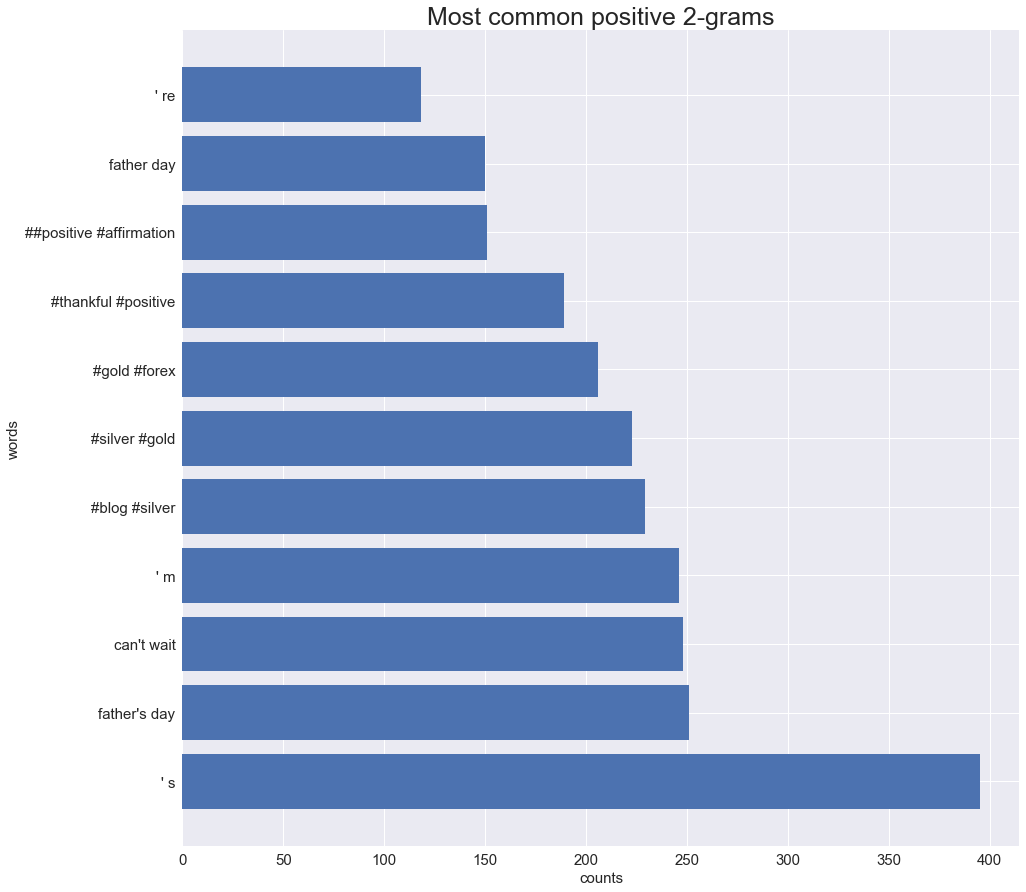

In [46]:
top_10_pos_2 = tokens_2_gram[:11]

fig, ax = plt.subplots(figsize = (15,15))

plt.style.use('seaborn')
ax.barh(top_10_pos_2['token'], top_10_pos_2['token_count'])
plt.xlabel('counts', fontsize=15)
plt.ylabel('words',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Most common positive 2-grams', fontsize=25)

#fig.savefig('yourfilename.png')

## WordCloud Positive words 2-gram (both ashtags and standard lexicon)

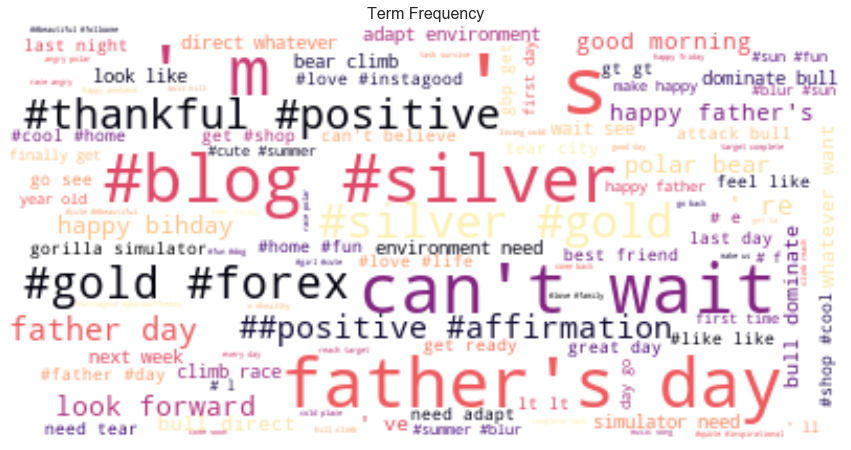

In [47]:
plot_word_cloud(tokens_2_gram,100)

## Top 10 Words 2-grams Negative

Text(0.5, 1.0, 'Most common negative 2-grams')

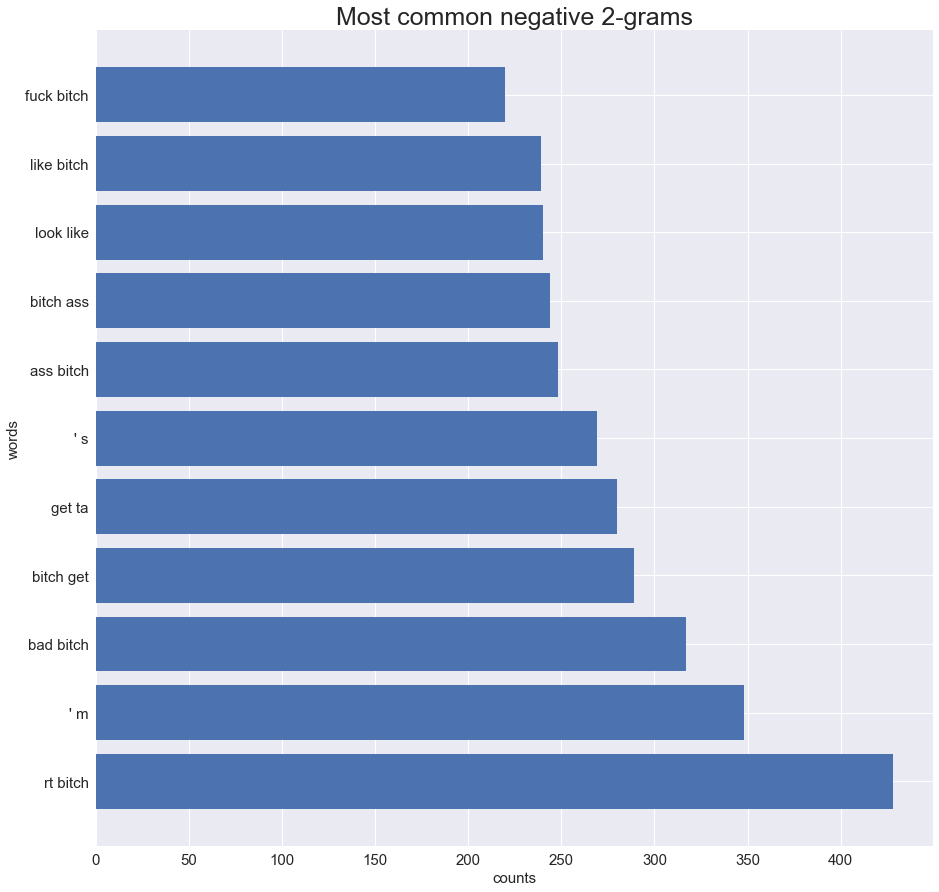

In [48]:
top_10_neg_2 = tokens_2_gram_neg[:11]

fig, ax = plt.subplots(figsize = (15,15))

plt.style.use('seaborn')
ax.barh(top_10_neg_2['token'], top_10_neg_2['token_count'])
plt.xlabel('counts', fontsize=15)
plt.ylabel('words',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Most common negative 2-grams', fontsize=25)

#fig.savefig('yourfilename.png')

## WordCloud Negative words 2-grams (both ashtags and standard lexicon)

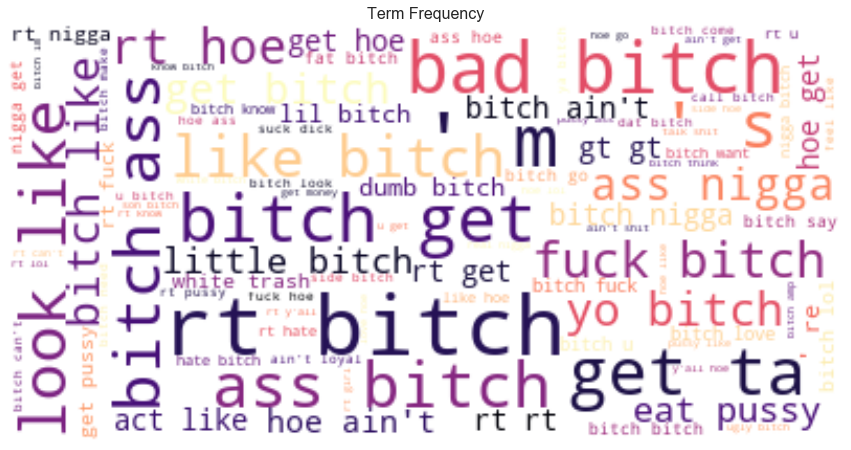

In [49]:
plot_word_cloud(tokens_2_gram_neg,100)

# Graphs most Recurring negative and positive words both ashtags and normal lexicon {3-gram}

##  Building 3-grams positive

In [50]:
df_pos_for_3_grams = df_pos[['no_handle_no_special_no_sin_ash', 'lemmatized_1', 'tweet_without_stopwords']]
df_pos_for_3_grams

,no_handle_no_special_no_sin_ash,lemmatized_1,tweet_without_stopwords
0,days to go #gettingthere,day to go #gettingthere,day go # gettingthere
3,a friend just told me she's afraid to go to dc rally amp be attacked by #berniebros or the racists cuz she's not white,a friend just tell me she 's afraid to go to dc rally amp be attack by #berniebros or the racist cuz she 's not white,friend tell 's afraid go dc rally amp attack # berniebros racist cuz 's white
4,i've noticed a lot of #icontf presentations mention happiness wonder if profession has above average happiness,i 've notice a lot of #icontf presentation mention happiness wonder if profession have above average happiness,'ve notice lot # icontf presentation mention happiness wonder profession average happiness
5,getting for this weekends shows #country #music #lylepierce,get for this weekend show #country #music #lylepierce,get weekend show # country # music # lylepierce
6,my final legislative session day has officially begun #albany,my final legislative session day have officially begin #albany,final legislative session day officially begin # albany
...,...,...,...
42021,'' x'mas amp my bihday disney '' #love #thanks #karen,`` x'mas amp my bihday disney `` #love #thanks #karen,`` x'mas amp bihday disney `` # love # thanks # karen
42022,my soul is happiest on the water #soul #happier #happiest #water #ocean #beach #cali,my soul be happiest on the water #soul #happy #happy #water #ocean #beach #cali,soul happiest water # soul # happy # happy # water # ocean # beach # cali
42023,#nzd usd post rbnz rally almost reversed closer #blog #silver #gold #forex,#nzd usd post rbnz rally almost reverse closer #blog #silver #gold #forex,# nzd usd post rbnz rally almost reverse closer # blog # silver # gold # forex
42025,#bihday to leo's mom #celia,#bihday to leo 's mom #celia,# bihday leo 's mom # celia


In [51]:
df_pos_for_3_grams['tweet_without_stopwords'] = df_pos_for_3_grams['tweet_without_stopwords'].str.replace("# ", "#")
df_pos_for_3_grams['tweet_without_stopwords'] = df_pos_for_3_grams['tweet_without_stopwords'].str.replace(" n't", "n't")
df_pos_for_3_grams['tweet_without_stopwords'] = df_pos_for_3_grams['tweet_without_stopwords'].str.replace(" '", "'")
df_pos_for_3_grams['tweet_without_stopwords'] = df_pos_for_3_grams['tweet_without_stopwords'].str.replace("gon na", "gonna")
df_pos_for_3_grams['tweet_without_stopwords'] = df_pos_for_3_grams['tweet_without_stopwords'].str.replace("' m", "'m")
df_pos_for_3_grams['tweet_without_stopwords'] = df_pos_for_3_grams['tweet_without_stopwords'].str.replace("' ve", "'ve")
df_pos_for_3_grams['tweet_without_stopwords'] = df_pos_for_3_grams['tweet_without_stopwords'].str.replace("' re", "'re")
df_pos_for_3_grams['tweet_without_stopwords'] = df_pos_for_3_grams['tweet_without_stopwords'].str.replace("' ll", "'ll")
df_pos_for_3_grams['tweet_without_stopwords'] = df_pos_for_3_grams['tweet_without_stopwords'].str.replace("wan na", "wanna")


In [52]:
df_pos_for_3_grams.head(5)

,no_handle_no_special_no_sin_ash,lemmatized_1,tweet_without_stopwords
0,days to go #gettingthere,day to go #gettingthere,day go #gettingthere
3,a friend just told me she's afraid to go to dc rally amp be attacked by #berniebros or the racists cuz she's not white,a friend just tell me she 's afraid to go to dc rally amp be attack by #berniebros or the racist cuz she 's not white,friend tell's afraid go dc rally amp attack #berniebros racist cuz's white
4,i've noticed a lot of #icontf presentations mention happiness wonder if profession has above average happiness,i 've notice a lot of #icontf presentation mention happiness wonder if profession have above average happiness,'ve notice lot #icontf presentation mention happiness wonder profession average happiness
5,getting for this weekends shows #country #music #lylepierce,get for this weekend show #country #music #lylepierce,get weekend show #country #music #lylepierce
6,my final legislative session day has officially begun #albany,my final legislative session day have officially begin #albany,final legislative session day officially begin #albany


In [53]:
# creating 3-grams
df_pos_for_3_grams['3_grams'] = df_pos_for_3_grams['tweet_without_stopwords'].apply(lambda x: [' '.join(ng) for ng in everygrams(tokenize_tweet(x), 3, 3)])



In [54]:
df_pos_for_3_grams

,no_handle_no_special_no_sin_ash,lemmatized_1,tweet_without_stopwords,3_grams
0,days to go #gettingthere,day to go #gettingthere,day go #gettingthere,[day go #gettingthere]
3,a friend just told me she's afraid to go to dc rally amp be attacked by #berniebros or the racists cuz she's not white,a friend just tell me she 's afraid to go to dc rally amp be attack by #berniebros or the racist cuz she 's not white,friend tell's afraid go dc rally amp attack #berniebros racist cuz's white,"[friend tell's afraid, tell's afraid go, afraid go dc, go dc rally, dc rally amp, rally amp attack, amp attack #berniebros, attack #berniebros racist, #berniebros racist cuz's, racist cuz's white]"
4,i've noticed a lot of #icontf presentations mention happiness wonder if profession has above average happiness,i 've notice a lot of #icontf presentation mention happiness wonder if profession have above average happiness,'ve notice lot #icontf presentation mention happiness wonder profession average happiness,"[' ve notice, ve notice lot, notice lot #icontf, lot #icontf presentation, #icontf presentation mention, presentation mention happiness, mention happiness wonder, happiness wonder profession, wonder profession average, profession average happiness]"
5,getting for this weekends shows #country #music #lylepierce,get for this weekend show #country #music #lylepierce,get weekend show #country #music #lylepierce,"[get weekend show, weekend show #country, show #country #music, #country #music #lylepierce]"
6,my final legislative session day has officially begun #albany,my final legislative session day have officially begin #albany,final legislative session day officially begin #albany,"[final legislative session, legislative session day, session day officially, day officially begin, officially begin #albany]"
...,...,...,...,...
42021,'' x'mas amp my bihday disney '' #love #thanks #karen,`` x'mas amp my bihday disney `` #love #thanks #karen,`` x'mas amp bihday disney `` #love #thanks #karen,"[` ` x'mas, ` x'mas amp, x'mas amp bihday, amp bihday disney, bihday disney `, disney ` `, ` ` #love, ` #love #thanks, #love #thanks #karen]"
42022,my soul is happiest on the water #soul #happier #happiest #water #ocean #beach #cali,my soul be happiest on the water #soul #happy #happy #water #ocean #beach #cali,soul happiest water #soul #happy #happy #water #ocean #beach #cali,"[soul happiest water, happiest water #soul, water #soul #happy, #soul #happy #happy, #happy #happy #water, #happy #water #ocean, #water #ocean #beach, #ocean #beach #cali]"
42023,#nzd usd post rbnz rally almost reversed closer #blog #silver #gold #forex,#nzd usd post rbnz rally almost reverse closer #blog #silver #gold #forex,#nzd usd post rbnz rally almost reverse closer #blog #silver #gold #forex,"[#nzd usd post, usd post rbnz, post rbnz rally, rbnz rally almost, rally almost reverse, almost reverse closer, reverse closer #blog, closer #blog #silver, #blog #silver #gold, #silver #gold #forex]"
42025,#bihday to leo's mom #celia,#bihday to leo 's mom #celia,#bihday leo's mom #celia,"[#bihday leo's mom, leo's mom #celia]"


In [55]:
tokens_3_gram = get_tokens_frequency_df(df_pos_for_3_grams['3_grams'])
tokens_3_gram = tokens_3_gram.sort_values(by='token_count', ascending = False)

In [56]:
tokens_3_gram.head(25)

,token,token_count,doc_appeared
token_id,,,
266,#blog #silver #gold,223,223
267,#silver #gold #forex,206,206
296,happy father's day,81,81
535,direct whatever want,65,65
536,dominate bull direct,65,65
534,bull dominate bull,65,65
533,bull direct whatever,65,65
1373,polar bear climb,60,30
1367,bear climb race,60,30


##  Building 3-grams Negative

In [57]:
df_neg_for_3_grams = df_neg[['no_handle_no_special_no_sin_ash', 'lemmatized_1', 'tweet_without_stopwords']]
df_neg_for_3_grams

,no_handle_no_special_no_sin_ash,lemmatized_1,tweet_without_stopwords
1,get off my twitter fag,get off my twitter fag,get twitter fag
2,these hoes got more bodies than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery
7,faggots,faggot,faggot
10,i found her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,find right good job unfollowing btw faggot
14,technology ain't doin nothing but making these hoes look better,technology ai n't doin nothing but make these hoe look good,technology ai n't doin nothing make hoe look good
...,...,...,...
42024,rt trash talked by many hated by some guess how many fucks i give its less than one,rt trash talk by many hat by some guess how many fuck i give its less than one,rt trash talk many hat guess many fuck give less one
42026,its swag bitch aha,its swag bitch aha,swag bitch aha
42028,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match pull niccas wit ya smfh shit like kill
42029,rt this is a true ride or die bitch,rt this be a true ride or die bitch,rt true ride die bitch


In [58]:
df_neg_for_3_grams['tweet_without_stopwords'] = df_neg_for_3_grams['tweet_without_stopwords'].str.replace("# ", "#")
df_neg_for_3_grams['tweet_without_stopwords'] = df_neg_for_3_grams['tweet_without_stopwords'].str.replace(" n't", "n't")
df_neg_for_3_grams['tweet_without_stopwords'] = df_neg_for_3_grams['tweet_without_stopwords'].str.replace(" '", "'")
df_neg_for_3_grams['tweet_without_stopwords'] = df_neg_for_3_grams['tweet_without_stopwords'].str.replace("gon na", "gonna")
df_neg_for_3_grams['tweet_without_stopwords'] = df_neg_for_3_grams['tweet_without_stopwords'].str.replace("' m", "'m")
df_neg_for_3_grams['tweet_without_stopwords'] = df_neg_for_3_grams['tweet_without_stopwords'].str.replace("' ve", "'ve")
df_neg_for_3_grams['tweet_without_stopwords'] = df_neg_for_3_grams['tweet_without_stopwords'].str.replace("' re", "'re")
df_neg_for_3_grams['tweet_without_stopwords'] = df_neg_for_3_grams['tweet_without_stopwords'].str.replace("' ll", "'ll")
df_neg_for_3_grams['tweet_without_stopwords'] = df_neg_for_3_grams['tweet_without_stopwords'].str.replace("wan na", "wanna")


In [59]:
df_neg_for_3_grams.head(5)

,no_handle_no_special_no_sin_ash,lemmatized_1,tweet_without_stopwords
1,get off my twitter fag,get off my twitter fag,get twitter fag
2,these hoes got more bodies than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery
7,faggots,faggot,faggot
10,i found her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,find right good job unfollowing btw faggot
14,technology ain't doin nothing but making these hoes look better,technology ai n't doin nothing but make these hoe look good,technology ain't doin nothing make hoe look good


In [60]:
# creating 3-grams
df_neg_for_3_grams['3_grams'] = df_neg_for_3_grams['tweet_without_stopwords'].apply(lambda x: [' '.join(ng) for ng in everygrams(tokenize_tweet(x), 3, 3)])



In [61]:
df_neg_for_3_grams

,no_handle_no_special_no_sin_ash,lemmatized_1,tweet_without_stopwords,3_grams
1,get off my twitter fag,get off my twitter fag,get twitter fag,[get twitter fag]
2,these hoes got more bodies than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,"[hoe get body, get body cemetery]"
7,faggots,faggot,faggot,[]
10,i found her right here good job unfollowing me btw faggot,i find her right here good job unfollowing me btw faggot,find right good job unfollowing btw faggot,"[find right good, right good job, good job unfollowing, job unfollowing btw, unfollowing btw faggot]"
14,technology ain't doin nothing but making these hoes look better,technology ai n't doin nothing but make these hoe look good,technology ain't doin nothing make hoe look good,"[technology ain't doin, ain't doin nothing, doin nothing make, nothing make hoe, make hoe look, hoe look good]"
...,...,...,...,...
42024,rt trash talked by many hated by some guess how many fucks i give its less than one,rt trash talk by many hat by some guess how many fuck i give its less than one,rt trash talk many hat guess many fuck give less one,"[rt trash talk, trash talk many, talk many hat, many hat guess, hat guess many, guess many fuck, many fuck give, fuck give less, give less one]"
42026,its swag bitch aha,its swag bitch aha,swag bitch aha,[swag bitch aha]
42028,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match pull niccas wit ya smfh shit like kill,"[rt hmu talmbout, hmu talmbout match, talmbout match pull, match pull niccas, pull niccas wit, niccas wit ya, wit ya smfh, ya smfh shit, smfh shit like, shit like kill]"
42029,rt this is a true ride or die bitch,rt this be a true ride or die bitch,rt true ride die bitch,"[rt true ride, true ride die, ride die bitch]"


In [62]:
tokens_3_gram_neg = get_tokens_frequency_df(df_neg_for_3_grams['3_grams'])
tokens_3_gram_neg =tokens_3_gram_neg.sort_values(by='token_count', ascending = False)

In [63]:
tokens_3_gram_neg.head(25)

,token,token_count,doc_appeared
token_id,,,
6963,gt gt gt,82,25
1293,bitch ass nigga,63,63
2572,hoe ain't loyal,60,60
362,#porn #android #iphone,45,45
361,#iphone #ipad #sex,45,45
360,#ipad #sex #xxx,45,45
359,#android #iphone #ipad,45,45
3115,bitch look like,37,37
3156,rt hoe ain't,30,30


## Top 10 words 3-grams positive

Text(0.5, 1.0, 'Most common positive 3-grams')

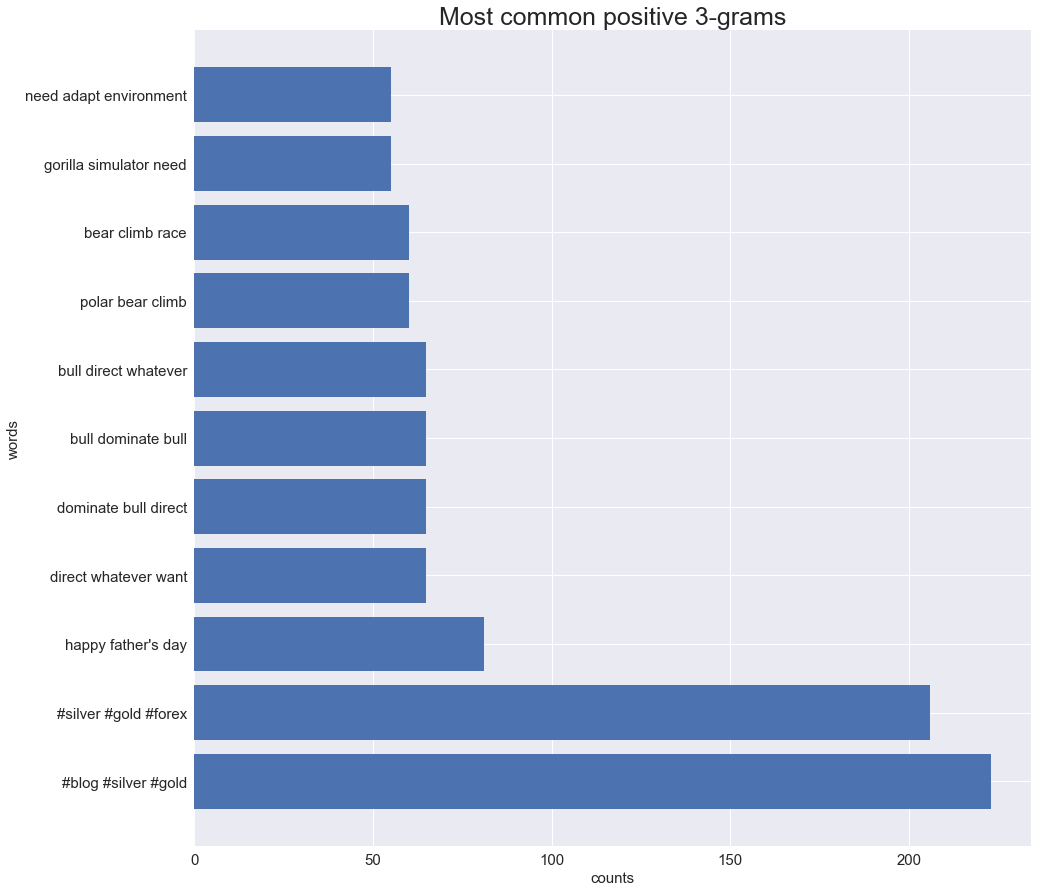

In [64]:
top_10_pos_3 = tokens_3_gram[:11]

fig, ax = plt.subplots(figsize = (15,15))

plt.style.use('seaborn')
ax.barh(top_10_pos_3['token'], top_10_pos_3['token_count'])
plt.xlabel('counts', fontsize=15)
plt.ylabel('words',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Most common positive 3-grams', fontsize=25)

#fig.savefig('yourfilename.png')

## WordCloud Positive words 3-grams (both ashtags and standard lexicon)

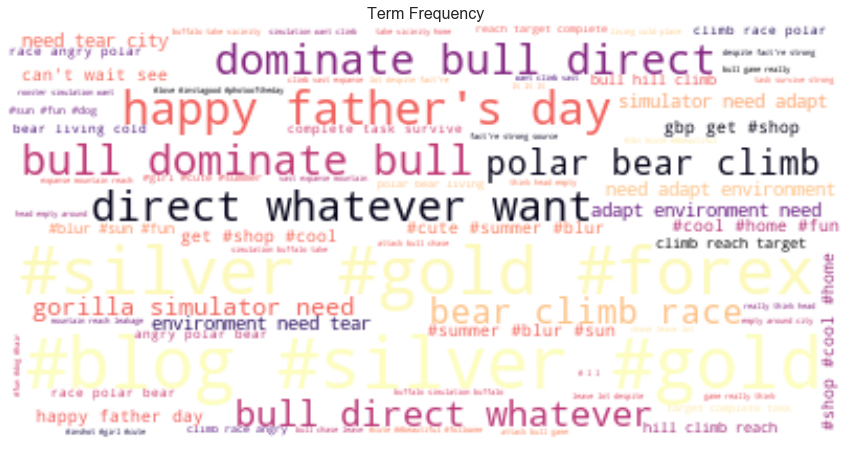

In [65]:
plot_word_cloud(tokens_3_gram,100)

## Top 10 Words 3-grams Negative

Text(0.5, 1.0, 'Most common negative 3-grams')

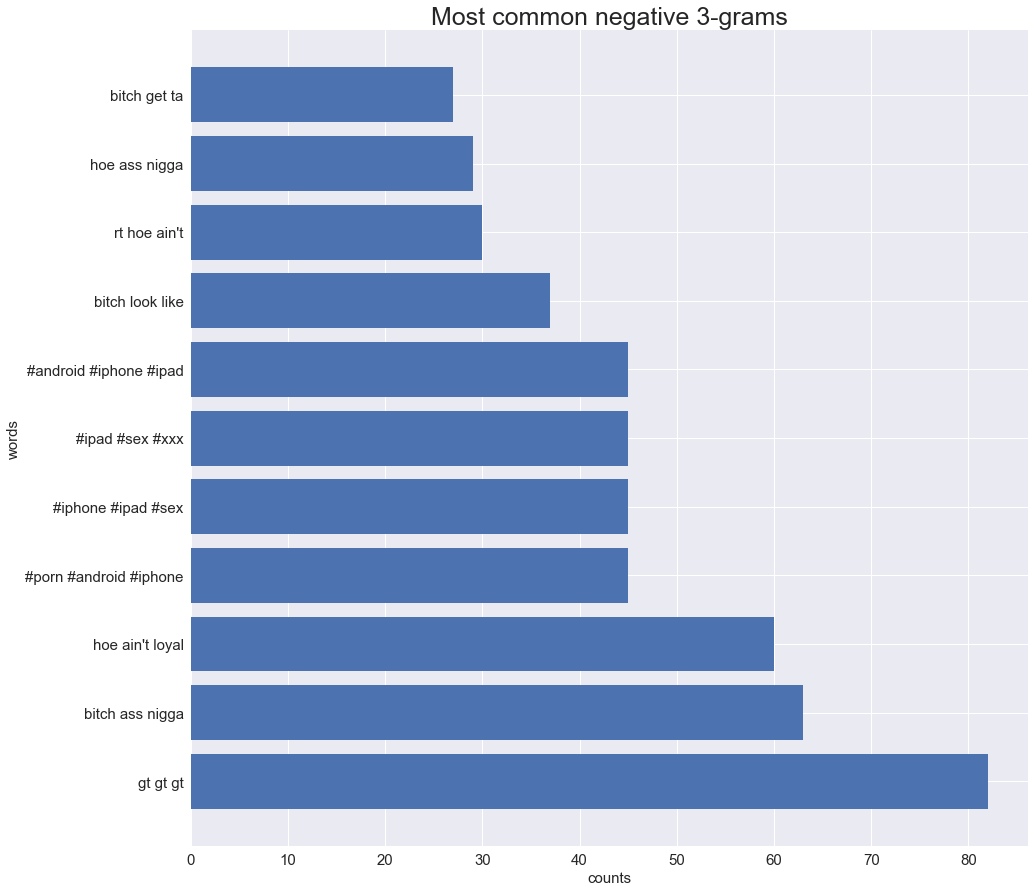

In [66]:
top_10_neg_3 = tokens_3_gram_neg[:11]

fig, ax = plt.subplots(figsize = (15,15))

plt.style.use('seaborn')
ax.barh(top_10_neg_3['token'], top_10_neg_3['token_count'])
plt.xlabel('counts', fontsize=15)
plt.ylabel('words',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Most common negative 3-grams', fontsize=25)

#fig.savefig('yourfilename.png')

## WordCloud Negative words 3-grams (both ashtags and standard lexicon)

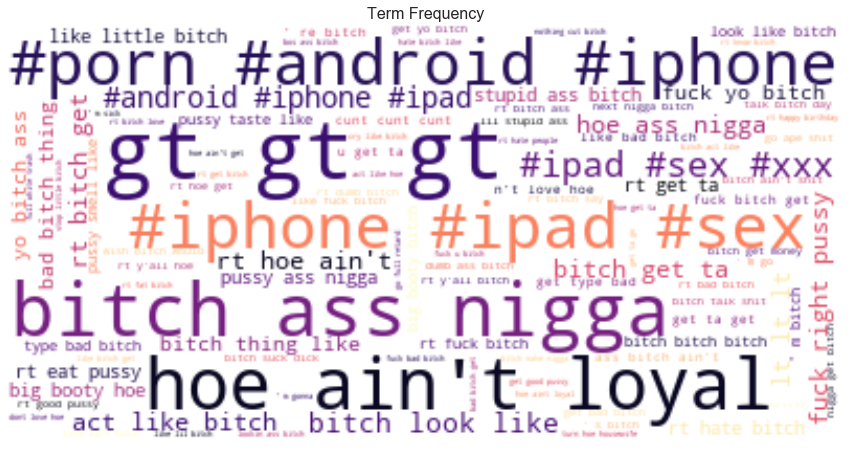

In [67]:
plot_word_cloud(tokens_3_gram_neg,100)

# Length and Profanity


Most of the positive tweets seem to have in between 40 and 80 characters.

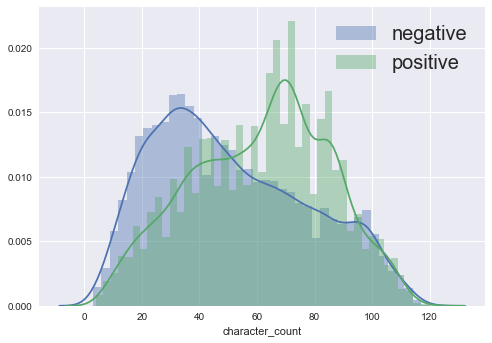

In [68]:
sns.distplot(df_neg['character_count'], label='negative')
sns.distplot(df_pos['character_count'], label='positive')
plt.legend(fontsize = 20)
plt.show()

Negative comments seem to be on average way shorter than their positive counterparts. This could also be due to the fact that offensive tweets use more emojis or alternative ways of communication. However, pure characters in terms of text are significantly less amongts negative comments.

In [69]:
pos_mean = df_pos['character_count'].mean()
pos_mean

61.182387878221014

In [70]:
pos_std = df_pos['character_count'].std()
pos_std

23.941652532716496

In [85]:
neg_mean = df_neg['character_count'].mean()
neg_mean

51.212965209374545

In [86]:
neg_std = df_neg['character_count'].std()
neg_std

26.730124000837616

Taking all the Tweets within one standard deviation of both negative and positive ones

In [90]:
df_length = df.loc[(df['character_count']> 30) &(df['character_count']<80)]
df_length['neg_label'].value_counts()

0    13554
1    11403
Name: neg_label, dtype: int64

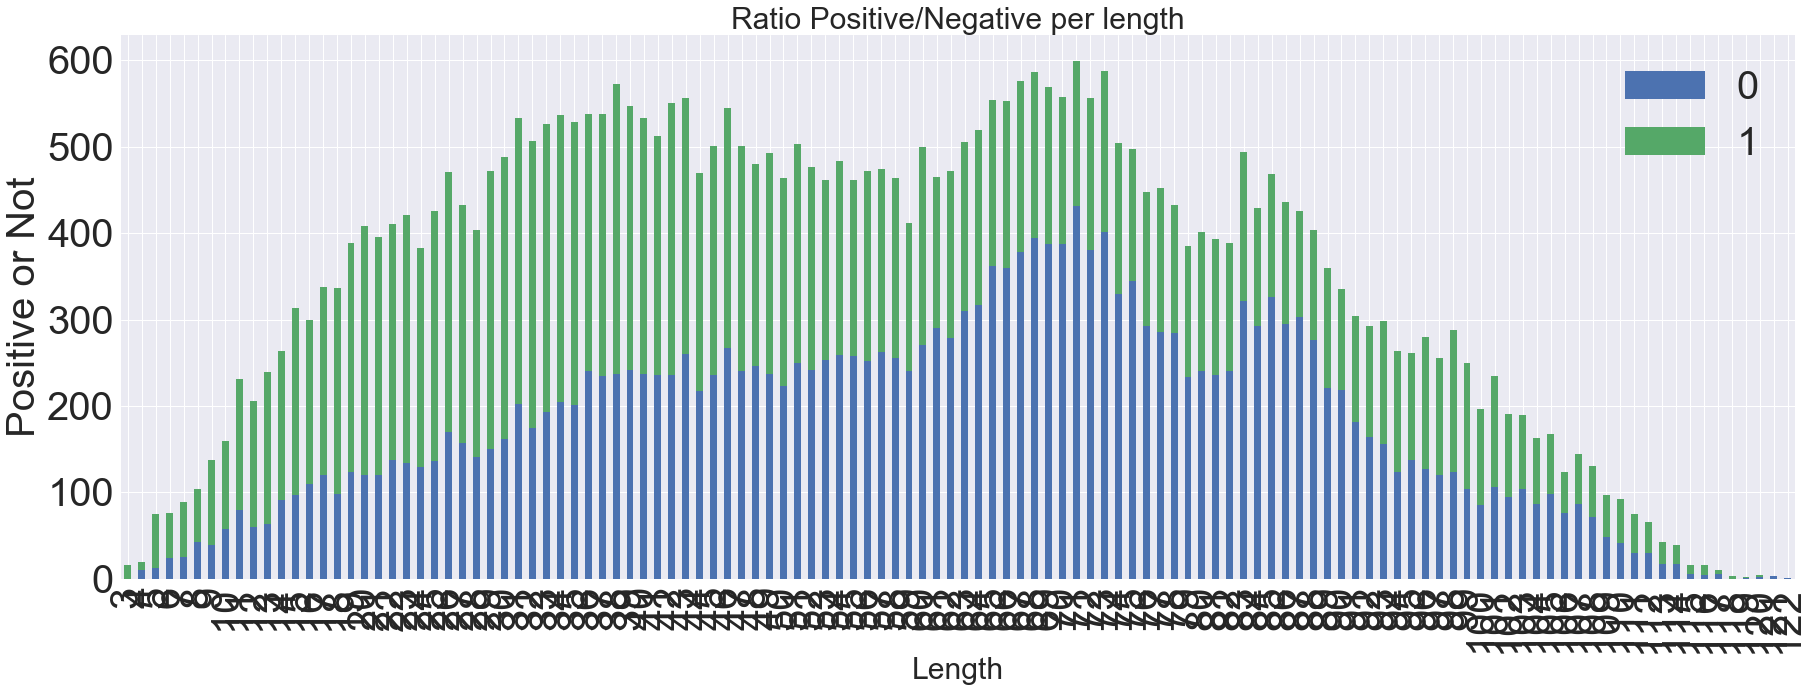

In [99]:
positive_grouped = df.groupby(["character_count", "neg_label"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10))
plt.style.use('seaborn')
plt.xlabel("Length", fontsize = 30)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
plt.ylabel("Positive or Not", fontsize = 40)
plt.legend (loc = 1, fontsize = 40)
plt.title ('Ratio Positive/Negative per length', fontsize = 30)
plt.show()

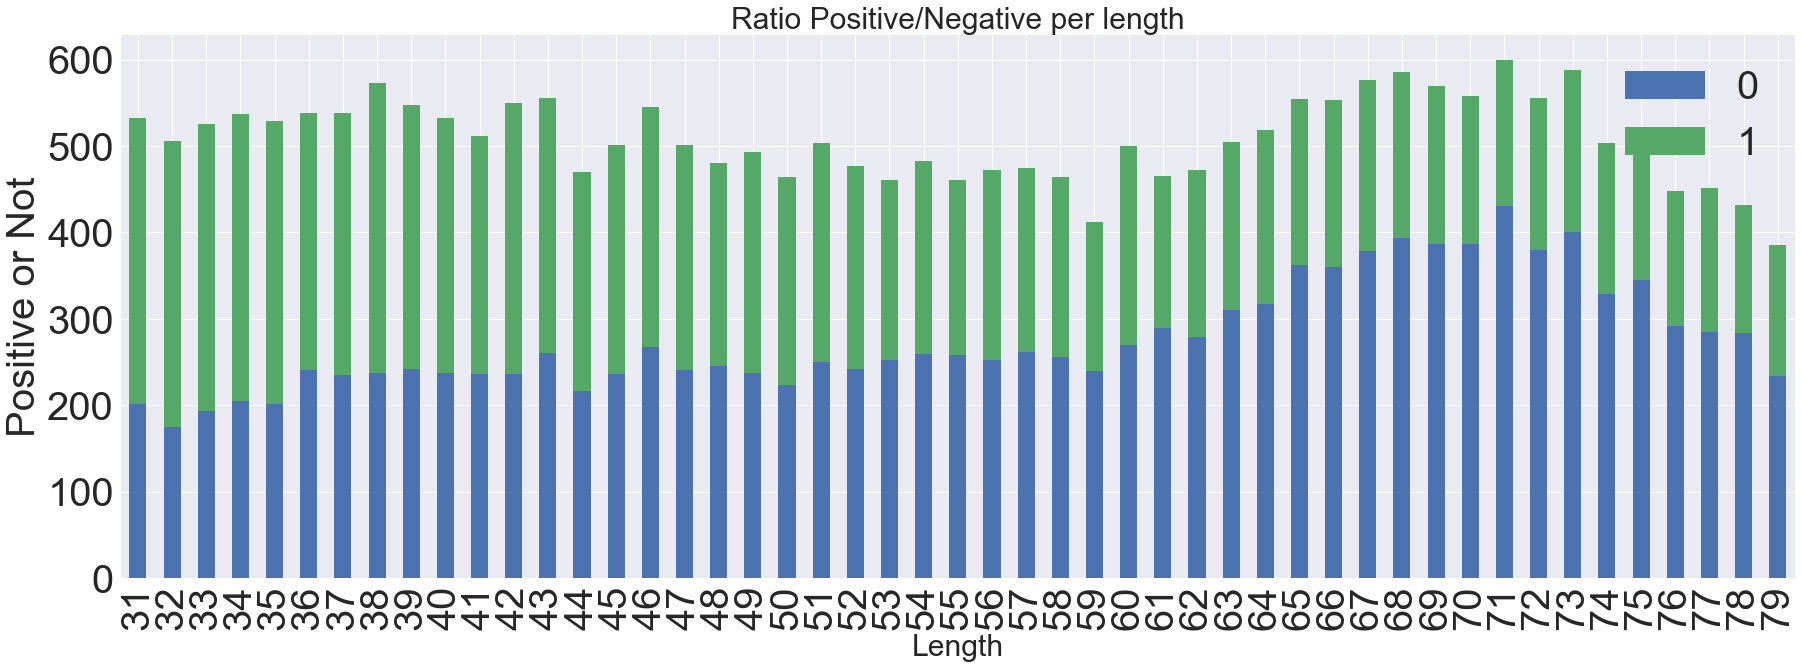

In [93]:
positive_grouped = df_length.groupby(["character_count", "neg_label"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10))
plt.style.use('seaborn')
plt.xlabel("Length", fontsize = 30)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
plt.ylabel("Positive or Not", fontsize = 40)
plt.legend (loc = 1, fontsize = 40)
plt.title ('Ratio Positive/Negative per length', fontsize = 30)
plt.show()

## Is there a statistically significant difference between the two?

It is reasonable to assume that the variance of the two groups is similar, so we'll use a simple t-test in this case (and not Welch).

In [94]:
t , p = stats.ttest_ind(df_pos['character_count'], 
                df_neg['character_count'],
                equal_var=True
               )

print(f't-critical value is {t}')
print(f'P-value is {p}')

t-critical value is 40.28992186454786
P-value is 0.0


Yes, very very strong!

# Number of Twitter handles and offensive language

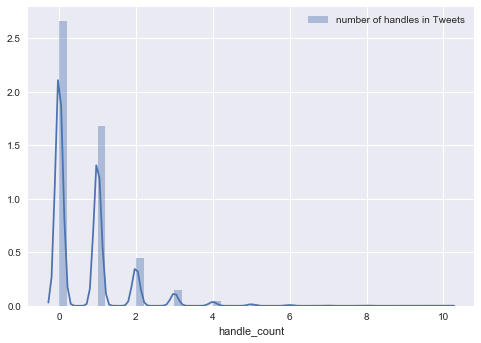

In [96]:
sns.distplot(df['handle_count'], label = 'number of handles in Tweets')
plt.legend()
plt.show()

In [97]:
df['handle_count'].value_counts()

0     22334
1     14067
2     3728 
3     1210 
4     375  
5     146  
6     74   
7     24   
8     22   
9     10   
10    2    
Name: handle_count, dtype: int64

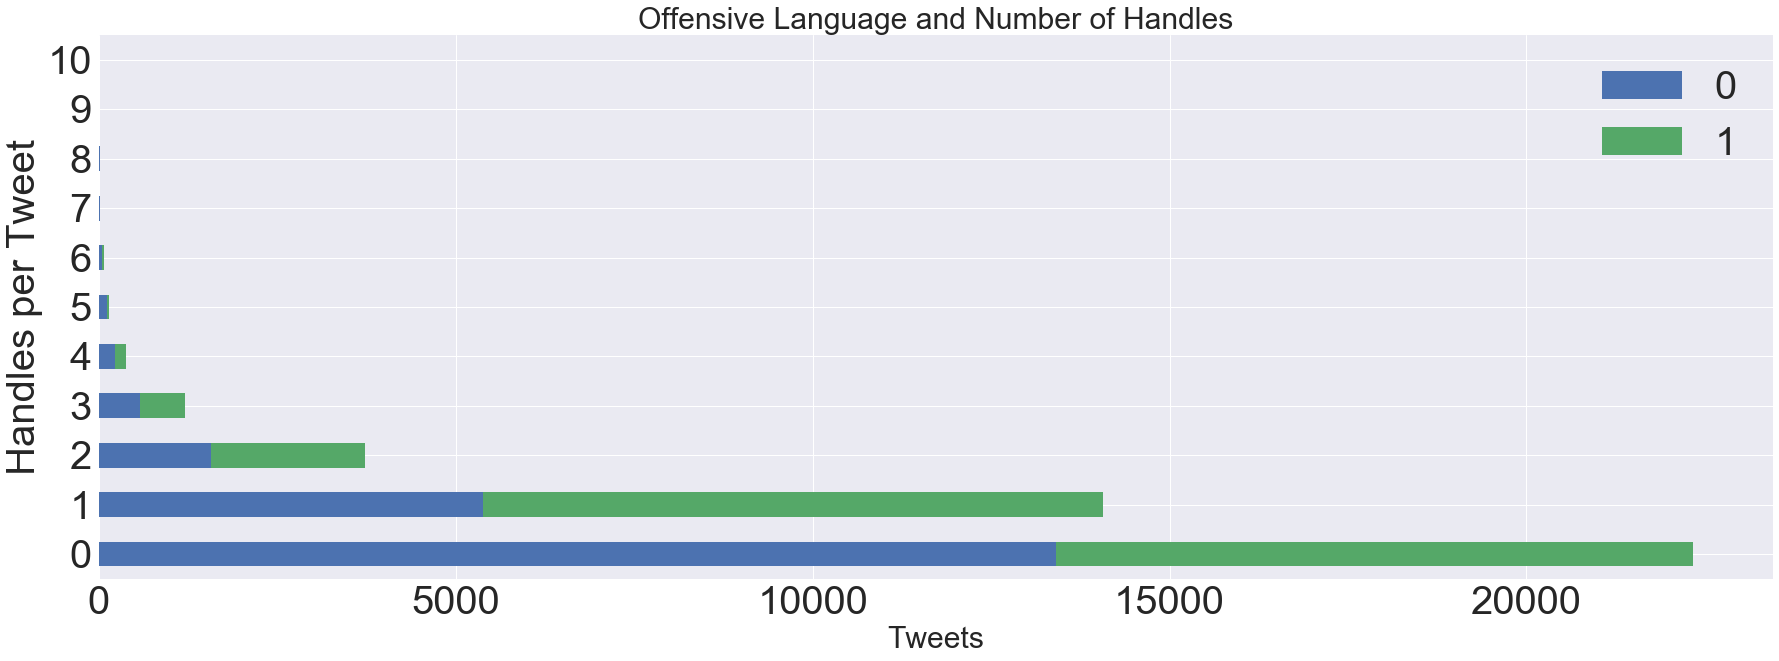

In [100]:
positive_grouped = df.groupby(["handle_count", "neg_label"]).size().unstack().plot(kind='barh', stacked=True, figsize=(30,10))
plt.style.use('seaborn')
plt.xlabel("Tweets", fontsize = 30)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
plt.ylabel("Handles per Tweet", fontsize = 40)
plt.legend (loc = 1, fontsize = 40)
plt.title ('Offensive Language and Number of Handles', fontsize = 30)
plt.show()

There seems to be a relationship between handles and offensive language. Apart from the 0 class where positive comments are the majority. For the remaining other classes with 1, 2 or 3 handles. The majority of Tweets seeem to be offensive. This would make sense in all cases where an offence was actually directed to someone. <4 classes are not taken into account as the samples are too small.

# Saving DF for modelling

In [101]:
df

,tweet_low,handle_count,no_handle_no_special_no_sin_ash,tweet_length,character_count,lemmatized,lemmatized_1,lemmatized_final,tweet_without_stopwords,tweet_without_stopwords_and_2,neg_label
0,13 days to go #gettingthere,0,days to go #gettingthere,30,21,day to go # gettingthere,day to go #gettingthere,day to go # gettingthere,day go # gettingthere,day gettingthere,0
1,@anggxo get off my twitter fag,1,get off my twitter fag,23,18,get off my twitter fag,get off my twitter fag,get off my twitter fag,get twitter fag,get twitter fag,1
2,these hoes got more bodies than a cemetery&#128056;&#9749;&#65039;.,0,these hoes got more bodies than a cemetery,58,35,these hoe get more body than a cemetery,these hoe get more body than a cemetery,these hoe get more body than a cemetery,hoe get body cemetery,hoe get body cemetery,1
3,a friend just told me she's afraid to go to dc rally &amp; be attacked by #berniebros or the @user racists cuz she's not white.,1,a friend just told me she's afraid to go to dc rally amp be attacked by #berniebros or the racists cuz she's not white,124,95,a friend just tell me she 's afraid to go to dc rally amp be attack by # berniebros or the racist cuz she 's not white,a friend just tell me she 's afraid to go to dc rally amp be attack by #berniebros or the racist cuz she 's not white,a friend just tell me she's afraid to go to dc rally amp be attack by # berniebros or the racist cuz she's not white,friend tell 's afraid go dc rally amp attack # berniebros racist cuz 's white,friend tell afraid rally amp attack berniebros racist cuz white,0
4,i've noticed a lot of #icontf16 presentations mention happiness. wonder if profession has above average happiness? @user,1,i've noticed a lot of #icontf presentations mention happiness wonder if profession has above average happiness,117,95,i 've notice a lot of # icontf presentation mention happiness wonder if profession have above average happiness,i 've notice a lot of #icontf presentation mention happiness wonder if profession have above average happiness,i've notice a lot of # icontf presentation mention happiness wonder if profession have above average happiness,'ve notice lot # icontf presentation mention happiness wonder profession average happiness,'ve notice lot icontf presentation mention happiness wonder profession average happiness,0
...,...,...,...,...,...,...,...,...,...,...,...
42026,@_elenaraquel_ its swag bitch aha,1,its swag bitch aha,19,15,its swag bitch aha,its swag bitch aha,its swag bitch aha,swag bitch aha,swag bitch aha,1
42027,when quay collab with @user says sold out!!!ð©ð«ð©ð«ð©ð«ð©ð«ð©ð«ð©ð«ð© #noooo #whyyyy #loveyoudesi #,1,when quay collab with says sold out #noooo #whyyyy #loveyoudesi,121,54,when quay collab with say sell out # noooo # whyyyy # loveyoudesi,when quay collab with say sell out #noooo #whyyyy #loveyoudesi,when quay collab with say sell out # noooo # whyyyy # loveyoudesi,quay collab say sell # noooo # whyyyy # loveyoudesi,quay collab say sell noooo whyyyy loveyoudesi,0
42028,rt @_groovymovie: &#8220;@shane_a1: hmu talmbout match but when i pull up its 30 other niccas wit ya &#128530;&#8221; smfh shit like that kill me,2,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,114,73,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match but when i pull up its other niccas wit ya smfh shit like that kill me,rt hmu talmbout match pull niccas wit ya smfh shit like kill,hmu talmbout match pull niccas wit smfh shit like kill,1
42029,rt @obey_jrock__: this is a true ride or die bitch &#128175; http://t.co/y1t8ctqn4u,1,rt this is a true ride or die bitch,45,27,rt this be a true ride or die bitch,rt this be a true ride or die bitch,rt this be a true ride or die bitch,rt true ride die bitch,true ride die bitch,1


In [102]:
# saving file
df.to_csv(r'../data/processed/data_for_modelling.csv', index = False)